In [1]:
#libraries
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parents[0]) 

In [2]:
pwd

'/mnt/c/Users/maxpu/Dropbox/scripts/Projects/abstraction'

In [3]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
# from STOMPnet import STOMPnet,Decoder
# from STOMPnet2 import STOMPnet2
# from utils import MultiChannelNet, get_width, count_parameters
from models import get_width
import h5py
import yaml
import json
import hashlib
import wandb

Pull a dataset to use to initialize a network

In [4]:
def get_runs():
    api = wandb.Api()
    runs = api.runs("STOMP")
    summary_list, config_list, name_list, state_list = [], [], [], []
    for run in runs:
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        state_list.append(run.state)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list, "state": state_list}
    )

    runs_df.to_csv("project.csv")
    runs_df.loc[:,['state','config']].apply(lambda run: run.state+
                                           ': N'+str(run.config['num_agents'])+
                                           ', P'+str(run.config['P'])+
                                           ' '+run.config['model_name'] if run.state=='finished' else run.state,axis=1)
    return runs_df
runs_df=get_runs()

In [5]:
train_config=runs_df.iloc[0].config
print(json.dumps(train_config,sort_keys=True, indent=4))
config_filename = train_config['outdir'] + train_config['data_dir'] + 'config.yaml'
with open(config_filename, 'r') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)['file_attrs']
    print(json.dumps(data_config,sort_keys=True, indent=4))

{
    "L": 100,
    "M": 2,
    "P": 10000000.0,
    "action_space_dim": 2,
    "batch_size": 8,
    "checkpoint_interval": 100,
    "data_dir": "data_75816d80b9/",
    "data_seed": 0,
    "enc2dec_ratio": 1,
    "epochs": 100,
    "learning_rate": 0.0001,
    "model_name": "stomp2",
    "n_features": 128,
    "n_hidden_layers": 2,
    "num_action_samples": 1280,
    "num_agents": 10,
    "num_codebooks": 10,
    "num_parameters": 1300,
    "outdir": "output/",
    "seed": 0,
    "state_space_dim": 3,
    "wandb_entity": null
}
{
    "A": 2,
    "K": 3,
    "M": 2,
    "N": 10,
    "T": 128,
    "action_selection_method": "greedy",
    "corr": 1.0,
    "ensemble": "sum",
    "env": false,
    "ground_model_name": "bitpop",
    "hash": "75816d80b9",
    "num_episodes": 1,
    "num_seeds": 10,
    "num_warmup_steps": 100,
    "output": "output/",
    "sps": 16,
    "stablefac": 8.0,
    "timestamp": "20240415_220711"
}


define function that initializes network

In [6]:
def get_untrained_net(training_dict,data_settings,hidden_dim,model_name):
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     print(f"Using {device} device", flush=True)
    args=training_dict.copy()
    action_space_dim = 2
    state_space_dim = data_settings['K']
    num_agents = int(data_settings['N'])
    # Initialize abstraction system model
    n_hidden_layers = args["n_hidden_layers"]
    if model_name == 'stomp':
        # to match the M generated by joint policy of ground model set as: data_settings['sys_parameters']['jointagent_groundmodel_paras']['M']
        net = STOMPnet(
            state_space_dim = state_space_dim,
            abs_action_space_dim = args["L"],
            enc_hidden_dim = hidden_dim,
            dec_hidden_dim = int(args["enc2dec_ratio"]*hidden_dim),
            num_agents=num_agents,
            num_abs_agents = args["M"],
            action_space_dim=action_space_dim,
            agent_embedding_dim= args["n_features"],
            n_hidden_layers=n_hidden_layers,
            num_codebooks=args["num_codebooks"]
        )
    elif model_name == 'stomp2':
        # to match the M generated by joint policy of ground model set as: data_settings['sys_parameters']['jointagent_groundmodel_paras']['M']
        net = STOMPnet2(
            state_space_dim = state_space_dim, 
            dec_hidden_dim = hidden_dim, 
            num_agents=num_agents, 
            num_abs_agents = args["M"], 
            action_space_dim=action_space_dim, 
            agent_embedding_dim=args["n_features"], 
            n_hidden_layers=n_hidden_layers
        )
    elif model_name == 'single':
        net = MultiChannelNet(
            n_channels=num_agents,
            input_size=state_space_dim,
            hidden_layer_width= hidden_dim,
            n_hidden_layers=n_hidden_layers,
            output_size=action_space_dim
        )
    elif model_name == 'multi':
        net = MultiChannelNet(
            n_channels=1,
            input_size=state_space_dim,
            hidden_layer_width= hidden_dim,
            n_hidden_layers=n_hidden_layers,
            output_size=num_agents*action_space_dim,
            output_dim=(num_agents, action_space_dim)
        )
    elif model_name == 'decoderonly':
        #feeds state directly into decoder by overloading the assigned abstract action input
        net = Decoder(
            num_agents=num_agents, 
            abs_action_space_dim=state_space_dim, 
            action_space_dim=action_space_dim, 
            agent_embedding_dim=args["n_features"], 
            n_hidden_layers=n_hidden_layers, 
            hidden_layer_width=int(args["enc2dec_ratio"]*hidden_dim)
        )
    else:
        print('choose valid model', flush=True)
#     net.to(device)
    return net
    

Validation

In [7]:
model_names = ['stomp', 'stomp2','decoderonly','multi','single']

In [9]:
Nvec=[1e1,1e2,1e3,1e4]
Pvec= [1e6,1e7,1e8,1e9]
df=pd.DataFrame(columns=('model_name','P','N','width','Pactual'))
for mit,model_name in enumerate(model_names):
    train_config['model_name'] = model_name
    for num_paras in Pvec:
        train_config['P'] = num_paras
        train_config["n_features"]= 2
        Wvec=[]
        for N in Nvec:
            data_config['N']=N
            solver_dict = {"model_name": train_config['model_name'],
                "n_hidden_layers": train_config['n_hidden_layers'],
                "num_abs_agents": train_config['M'],
                "abs_action_space_dim": train_config['L'],
                "n_features": train_config['n_features'],
                "num_agents": data_config['N'],
                "state_space_dim": data_config['K'],
                "action_space_dim": data_config['A'],
                "enc2dec_ratio": train_config['enc2dec_ratio'],
                "num_parameters": train_config['P']
                 }
            hidden_dim = int(get_width(solver_dict))
#             print(hidden_dim)
            Wvec.append(hidden_dim)        
#         data_settings['sys_parameters']['K']=10   
            net=get_untrained_net(train_config,data_config,hidden_dim,model_name)
            P_actual = count_parameters(net)
            df=df.append({
                            'model_name':model_name,
                            'P':np.log10(train_config['P']),
                            'N':N,
                            'width':hidden_dim,
                            'Pactual':P_actual
                        },ignore_index=True)

6
310
-999960.0
383.223338915282
6
310
-999600.0
383.149992868495
6
310
-996000.0
382.41580764691554
6
310
-960000.0
375.0
6
310
-9999960.0
1265.4169759061692
6
310
-9999600.0
1265.3937424016478
6
310
-9996000.0
1265.161384359621


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The fra

6
310
-9960000.0
1262.8354996532921
6
310
-99999960.0
4056.7304887166188


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-99999600.0
4056.7231403864257


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-99996000.0
4056.649656357023


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-99960000.0
4055.9147433013713


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-999999960.0
12884.136742585166


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-999999600.0
12884.134418799556


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-999996000.0
12884.11118092044


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6
310
-999960000.0
12883.878799828703


/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The fra

/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_12640/543664163.py:29: FutureWarning: The fra

In [10]:
import seaborn as sns

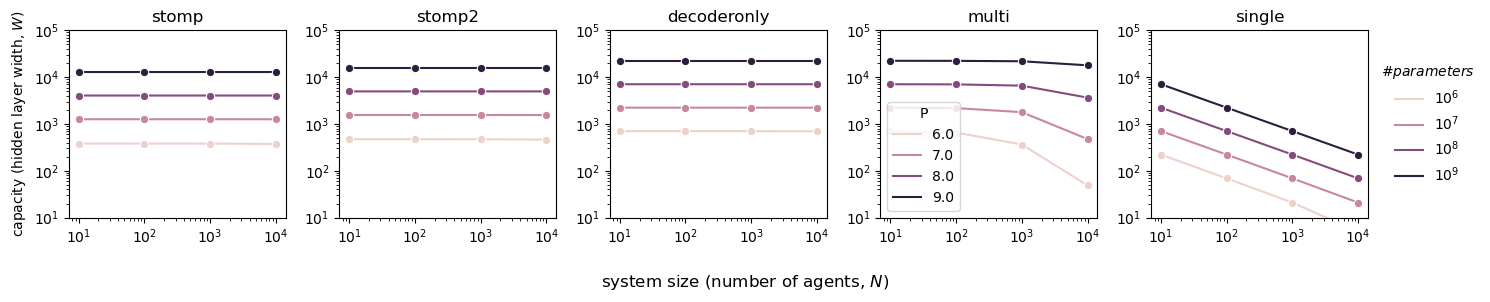

In [14]:
fig,ax=pl.subplots(1,len(model_names),figsize=(3*len(model_names),3))

for mit,model_name in enumerate(model_names):
    
#     ,label="{:.2e}".format(num_paras)
    sns.lineplot(data=df.loc[df['model_name']==model_name],
                    ax=ax[mit],
                    x='N',
                    y='width',
                    hue='P',
                    marker='o',
                    legend=False if mit<3 else True)
    if mit>0:
        ax[mit].set_ylabel(None)
    ax[mit].set_xlabel(None)
    ax[mit].set_yscale('log')
    ax[mit].set_xscale('log')
    ax[mit].set_ylim(1e1,1e5)
    ax[mit].set_title(model_name)
# ax[1].plot(np.logspace(1,4,10),10*np.logspace(1,4,10)[::-1]**(1/2))
ax[0].set_ylabel('capacity (hidden layer width, $W$)')
h, l = ax[len(model_names)-1].get_legend_handles_labels()
ax[len(model_names)-1].legend(h,[r"$10^"+string[0]+r"$" for string in l],frameon=False,title=r'$\# parameters$',loc='center left', bbox_to_anchor=(1, 0.5))  
fig.supxlabel(r'system size (number of agents, $N$)')
fig.tight_layout()

In [15]:
df['relative_error']=(10**df['P']-df['Pactual'])/df['Pactual']

<AxesSubplot: >

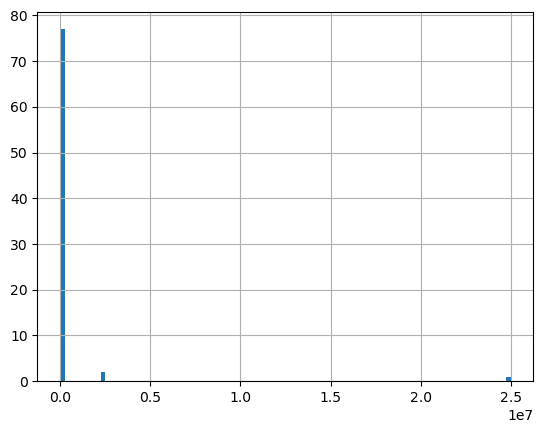

In [16]:
df["relative_error"].hist(bins=100)

now count parameters

In [16]:
data_config

{'A': 2,
 'K': 4,
 'M': 2,
 'N': 10000.0,
 'T': 16,
 'action_selection_method': 'greedy',
 'corr': 0.8,
 'ensemble': 'sum',
 'env': False,
 'ground_model_name': 'bitpop',
 'hash': 'deb6fe1a1c',
 'num_episodes': 1,
 'num_seeds': 10,
 'num_warmup_steps': 100,
 'output': 'output/',
 'sps': 1,
 'stablefac': 8.0,
 'timestamp': '20240420_110852'}

In [20]:
Nvec=[1e1,1e2,1e3,1e4]
hidden_dim =200
df=pd.DataFrame(columns=('model_name','P','N','width','Pactual'))
for mit,model_name in enumerate(model_names):
    train_config['model_name'] = model_name
    train_config['hidden_dim'] = hidden_dim
    Wvec=[]
    for N in Nvec:
        data_config['N']=N   
        net=get_untrained_net(train_config,data_config,hidden_dim,model_name)
        P_actual = count_parameters(net)
        df=df.append({
                        'model_name':model_name,
                        'N':N,
                        'Pactual':P_actual
                    },ignore_index=True)

Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device


/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: T

Using cpu device


/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_11389/1746127858.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


In [21]:
df

,model_name,P,N,width,Pactual
0,stomp,NaN,10.0,NaN,304442
1,stomp,NaN,100.0,NaN,304802
2,stomp,NaN,1000.0,NaN,308402
3,stomp,NaN,10000.0,NaN,344402
4,decoderonly,NaN,10.0,NaN,82222
5,decoderonly,NaN,100.0,NaN,82402
6,decoderonly,NaN,1000.0,NaN,84202
7,decoderonly,NaN,10000.0,NaN,102202
8,multi,NaN,10.0,NaN,85420
9,multi,NaN,100.0,NaN,121600


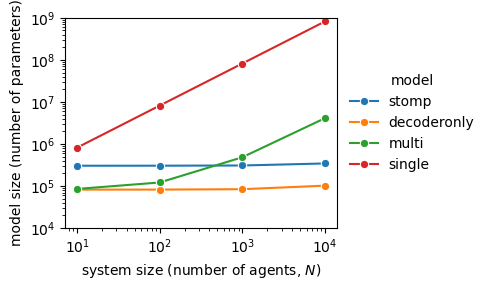

In [39]:
fig,ax=pl.subplots(1,1,figsize=(5,3))

for mit,model_name in enumerate(model_names):
#     ,label="{:.2e}".format(num_paras)
    sns.lineplot(data=df.loc[df['model_name']==model_name],
                    ax=ax,
                    x='N',
                    y='Pactual',
                    marker='o',
#                     legend=False if mit<3 else True
                 label=model_name
                )
    ax.set_xlabel(r'system size (number of agents, $N$)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e4,1e9)
# ax[1].plot(np.logspace(1,4,10),10*np.logspace(1,4,10)[::-1]**(1/2))
ax.set_ylabel('model size (number of parameters)')
# h, l = ax[3].get_legend_handles_labels()
ax.legend(frameon=False,title=r'model',loc='center left', bbox_to_anchor=(1, 0.5))  
fig.tight_layout()

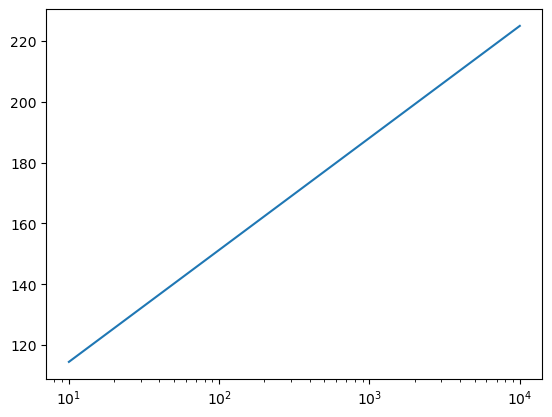

In [46]:
y=4-16*np.log(1-(1-0.01)**(1/np.array(Nvec)))
fig,ax=pl.subplots()
ax.plot(Nvec,y)
ax.set_xscale('log')

In [88]:
list(np.logspace(1,8,9))

[10.0,
 74.98942093324558,
 562.341325190349,
 4216.965034285822,
 31622.776601683792,
 237137.37056616554,
 1778279.410038923,
 13335214.32163324,
 100000000.0]

Text(0.5, 1.0, '$(\\epsilon,\\delta)=(10^{-2},10^{-2})$ PAC lower bound')

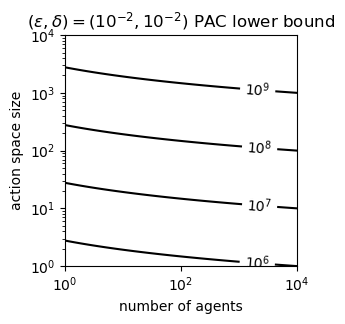

In [164]:
import matplotlib.ticker as ticker
fig,ax=pl.subplots(figsize=(3,3))
action_space_size=np.logspace(0,4,300)
Nvec=np.logspace(0,4,100)
X, Y = np.meshgrid(Nvec, action_space_size)
eps=0.01
delta=0.01
Z=np.log10(Y*(4-16*np.log10(1-(1-delta)**(1/X)))/eps**2)
ax.set_xscale('log')
ax.set_yscale('log')
levels=np.arange(6,11,1)
CS = pl.contour(X, 
                Y, 
                Z, 
                levels,
                extent=[X[0], X[-1], Y[0], Y[-1]],
                colors='black'
               )
fmt = {}
strs = [r'$10^{'+str(x)+'}$' for x in levels]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

# Label every other level using strings
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

# pl.imshow(Z, origin='lower',
#            cmap='RdGy', alpha=0.5)
# cbar=pl.colorbar();
# cbar.ax.set_ylabel('# of joint actions')#, rotation=270)
# cbar.ax.get_yaxis().set_ticks([])
ax.set_xlabel('number of agents')
ax.set_ylabel('action space size')
ax.set_title(r'$(\epsilon,\delta)=(10^{-2},10^{-2})$ PAC lower bound')